## Prepare Sensor Data for Machine Learning

#### Questions to consider?
* Is the data "clean"?
* Are there anomalies in the data?
* Should we use all the sensors?
* Is the 20Hz frequency a good frequency?
* What would be a good "time window" to aggregate the data given the movements we want to detect?
* What is an appropriate format to feed the algorithm?

### Install and Import required libraries (tools) to work with the data

In [1]:
## library to work with IBMs Object Storage
!pip install ibm-cos-sdk
## library to work with PostgreSQL Database
!pip install psycopg2-binary

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 3.0 MB 18.9 MB/s eta 0:00:01


In [2]:
import os
from datetime import datetime, timedelta
import psycopg2

import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime

import pytz
import time
from datetime import datetime
from dateutil import parser
import scipy.io as sio

import ibm_boto3
from botocore.client import Config

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Specify Database Connection

In [3]:
def connect_to_db(dbname,dbuser,dbpassword,dbhost,dbport,tablename):

    print( f"--- using {tablename} table ---")

    #print(dbname, user, password, host)
    try:
        conn = psycopg2.connect(dbname=dbname, user=dbuser, host=dbhost, port=dbport, password=dbpassword)
        cur = conn.cursor()
        print("connected to DB")
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("connection to db failed")

    return cur, conn, tablename

## Insert Database credentials

In [4]:
## click here and go to the right and "Connections" to insert database credentials

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
dbname = credentials_1['database']
dbuser = credentials_1['username']
dbpassword = credentials_1['password']
dbhost = credentials_1['host']
dbport = credentials_1['port']
tablename = "sensortraindata"

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
cur, conn, tablename = connect_to_db(dbname,dbuser,dbpassword,dbhost,dbport,tablename)

--- using sensortraindata table ---
connected to DB


### fetch the data and put it into a dataframe (table) and explore it a little

In [9]:
query = "SELECT * FROM " + tablename

In [10]:
df = pd.read_sql_query(query, conn)

In [11]:
df.head(20)

,id,username,sensortype,x,y,z,ts,class,device
0,1,maxisses,gyroscope,0.000000,0.0,0.0,1617886478687,lying,android
1,2,maxisses,accelerometer,-0.100000,1.0,9.5,1617886478689,lying,android
2,3,maxisses,gyroscope,0.000000,0.0,0.0,1617886478737,lying,android
3,4,maxisses,accelerometer,0.000000,1.0,9.5,1617886478741,lying,android
4,5,maxisses,gyroscope,0.000000,0.0,0.0,1617886478787,lying,android
5,6,maxisses,accelerometer,-0.100000,1.0,9.5,1617886478792,lying,android
6,7,maxisses,gyroscope,0.000000,0.0,0.0,1617886478837,lying,android
7,8,maxisses,accelerometer,-0.100000,1.0,9.5,1617886478841,lying,android
8,9,maxisses,gyroscope,0.000000,0.0,0.0,1617886478887,lying,android
9,10,maxisses,accelerometer,-0.100000,1.0,9.5,1617886478891,lying,android


In [12]:
## How many Data Points are available?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109100 entries, 0 to 109099
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          109100 non-null  int64  
 1   username    109100 non-null  object 
 2   sensortype  109100 non-null  object 
 3   x           109100 non-null  float64
 4   y           109100 non-null  float64
 5   z           109100 non-null  float64
 6   ts          109100 non-null  int64  
 7   class       109100 non-null  object 
 8   device      109100 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 7.5+ MB


In [13]:
## Our current users that provided training data
set(df["username"])

{'Max', 'Maxiphone', 'maxandroid', 'maxisses'}

In [14]:
## the specifics of the values
df[df["sensortype"] == "accelerometer"].describe()

,id,x,y,z,ts
count,54549.000000,54549.000000,54549.000000,54549.000000,5.454900e+04
mean,54544.841005,0.434548,0.326304,1.698150,1.618118e+12
std,31498.374157,6.255843,6.926642,5.488885,1.348806e+08
min,2.000000,-29.163322,-25.500000,-29.000000,1.617886e+12
25%,27260.000000,-3.600000,-5.235671,-1.200000,1.617958e+12
50%,54546.000000,0.100000,0.300000,0.600000,1.618206e+12
75%,81824.000000,4.973805,5.829433,6.800000,1.618206e+12
max,109098.000000,28.100000,24.890570,28.200000,1.618207e+12


In [15]:
## the specifics of the values
df[df["sensortype"] == "gyroscope"].describe()

,id,x,y,z,ts
count,54551.000000,54551.000000,54551.000000,54551.000000,5.455100e+04
mean,54556.158787,81.633558,-27.770841,0.424557,1.618118e+12
std,31491.116265,122.515591,44.653398,45.723151,1.348331e+08
min,1.000000,-4.475024,-171.741300,-89.997800,1.617886e+12
25%,27292.000000,0.000000,-49.432229,-0.893609,1.617958e+12
50%,54556.000000,0.535816,-0.310677,0.000000,1.618206e+12
75%,81825.500000,147.944560,0.000000,0.996583,1.618206e+12
max,109100.000000,359.999970,153.049710,89.999275,1.618207e+12


### put in a human readable timestamp

In [16]:
df['timestamp'] = pd.to_datetime(df['ts'], unit='ms')

In [17]:
df['timestamp'].describe()

count                         109100
unique                         98241
top       2021-04-12 05:38:46.713000
freq                               3
first     2021-04-08 12:54:38.687000
last      2021-04-12 05:54:57.799000
Name: timestamp, dtype: object

In [18]:
df.head(10)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
0,1,maxisses,gyroscope,0.0,0.0,0.0,1617886478687,lying,android,2021-04-08 12:54:38.687
1,2,maxisses,accelerometer,-0.1,1.0,9.5,1617886478689,lying,android,2021-04-08 12:54:38.689
2,3,maxisses,gyroscope,0.0,0.0,0.0,1617886478737,lying,android,2021-04-08 12:54:38.737
3,4,maxisses,accelerometer,0.0,1.0,9.5,1617886478741,lying,android,2021-04-08 12:54:38.741
4,5,maxisses,gyroscope,0.0,0.0,0.0,1617886478787,lying,android,2021-04-08 12:54:38.787
5,6,maxisses,accelerometer,-0.1,1.0,9.5,1617886478792,lying,android,2021-04-08 12:54:38.792
6,7,maxisses,gyroscope,0.0,0.0,0.0,1617886478837,lying,android,2021-04-08 12:54:38.837
7,8,maxisses,accelerometer,-0.1,1.0,9.5,1617886478841,lying,android,2021-04-08 12:54:38.841
8,9,maxisses,gyroscope,0.0,0.0,0.0,1617886478887,lying,android,2021-04-08 12:54:38.887
9,10,maxisses,accelerometer,-0.1,1.0,9.5,1617886478891,lying,android,2021-04-08 12:54:38.891


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


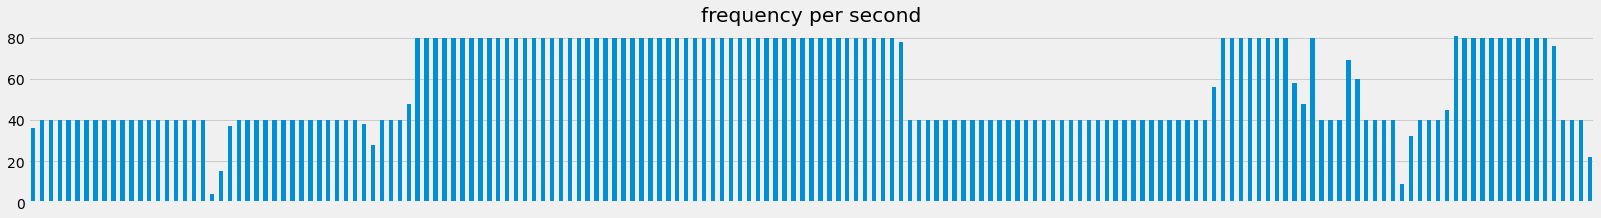

In [19]:
df["timestamp"][20000:30000].groupby([df["timestamp"].dt.day, df["timestamp"].dt.hour, df["timestamp"].dt.minute, df["timestamp"].dt.second]).count().plot(kind="bar", figsize=(25,3), title="frequency per second")
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


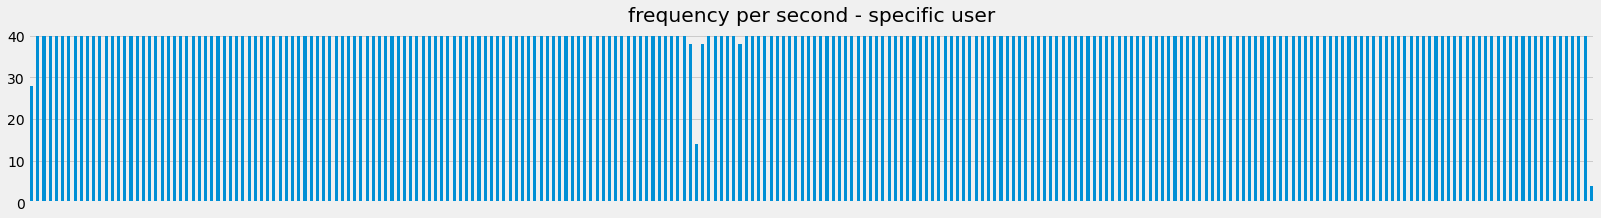

In [20]:
df[df["username"] == "Maxiphone"]["timestamp"][20000:30000].groupby([df["timestamp"].dt.day, df["timestamp"].dt.hour, df["timestamp"].dt.minute, df["timestamp"].dt.second]).count().plot(kind="bar", figsize=(25,3), title="frequency per second - specific user")
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

In [21]:
### What is the frequency of our sensors?? Why does the first plot have those strong spikes? What about the minor ones in the second diagram?

### Which classes / labels are in our dataset

In [22]:
classes = list(set(df["class"]))
classes

['lying', 'stairs', 'walking']

In [23]:
for label in classes:
    items_per_class = len(df[df["class"]==label].index)
    print(f"datapoints for class {label}: {items_per_class}")

datapoints for class lying: 30342
datapoints for class stairs: 29870
datapoints for class walking: 48888


In [24]:
### Is this a good sample?

### Sort by User and Timestamps

In [25]:
df.tail(20)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
109080,109081,maxandroid,accelerometer,1.100000,-0.400000,9.000000,1618206896432,walking,android,2021-04-12 05:54:56.432
109081,109082,Maxiphone,accelerometer,-1.454179,-3.052907,-8.840888,1618206897598,walking,ios,2021-04-12 05:54:57.598
109082,109083,Maxiphone,gyroscope,236.307940,21.897049,-10.198539,1618206897598,walking,ios,2021-04-12 05:54:57.598
109083,109084,maxandroid,gyroscope,0.357793,-0.143117,0.280998,1618206896460,walking,android,2021-04-12 05:54:56.460
109084,109085,maxandroid,accelerometer,1.300000,0.300000,9.200000,1618206896474,walking,android,2021-04-12 05:54:56.474
109085,109086,Maxiphone,accelerometer,-0.788891,-3.698294,-9.173683,1618206897649,walking,ios,2021-04-12 05:54:57.649
109086,109087,Maxiphone,gyroscope,236.698850,21.731640,-10.004827,1618206897649,walking,ios,2021-04-12 05:54:57.649
109087,109088,maxandroid,gyroscope,-0.085521,0.029671,0.518363,1618206896511,walking,android,2021-04-12 05:54:56.511
109088,109089,maxandroid,accelerometer,1.500000,0.600000,8.800000,1618206896515,walking,android,2021-04-12 05:54:56.515
109089,109090,Maxiphone,accelerometer,-1.183934,-4.023306,-9.607632,1618206897698,walking,ios,2021-04-12 05:54:57.698


In [26]:
df_sorted = df.sort_values(['username', 'ts'], ascending=[True, True])

In [27]:
df_sorted[df_sorted["username"] == "Maxiphone"].tail(10)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
109081,109082,Maxiphone,accelerometer,-1.454179,-3.052907,-8.840888,1618206897598,walking,ios,2021-04-12 05:54:57.598
109082,109083,Maxiphone,gyroscope,236.307940,21.897049,-10.198539,1618206897598,walking,ios,2021-04-12 05:54:57.598
109085,109086,Maxiphone,accelerometer,-0.788891,-3.698294,-9.173683,1618206897649,walking,ios,2021-04-12 05:54:57.649
109086,109087,Maxiphone,gyroscope,236.698850,21.731640,-10.004827,1618206897649,walking,ios,2021-04-12 05:54:57.649
109089,109090,Maxiphone,accelerometer,-1.183934,-4.023306,-9.607632,1618206897698,walking,ios,2021-04-12 05:54:57.698
109090,109091,Maxiphone,gyroscope,237.230210,21.415565,-10.035651,1618206897698,walking,ios,2021-04-12 05:54:57.698
109093,109094,Maxiphone,accelerometer,-1.677140,-3.610307,-9.661502,1618206897748,walking,ios,2021-04-12 05:54:57.748
109094,109095,Maxiphone,gyroscope,237.522810,21.272512,-10.174491,1618206897748,walking,ios,2021-04-12 05:54:57.748
109097,109098,Maxiphone,accelerometer,-1.158047,-3.840599,-8.825327,1618206897798,walking,ios,2021-04-12 05:54:57.798
109098,109099,Maxiphone,gyroscope,237.225540,21.818727,-10.509635,1618206897799,walking,ios,2021-04-12 05:54:57.799


In [28]:
### What could be good reasons for sorting the table by username first and then by timestamp?

### Investigate our two sensor more thorougly?

#### Give numbers to classes for coloring in 3D scatter

In [29]:
df_sorted['class_num'] = pd.factorize(df_sorted['class'])[0]
colors = np.array(["green", "black", "red"])

In [30]:
df_sorted["class"].unique()

array(['lying', 'walking', 'stairs'], dtype=object)

In [31]:
df_sorted["class_num"].unique()

array([0, 1, 2])

In [32]:
gyro_colors_ios = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "ios"]["class_num"]
gyro_colors_android = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "android"]["class_num"]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Text(0.5, 0.92, 'Gyroscope Data for Android Devices')

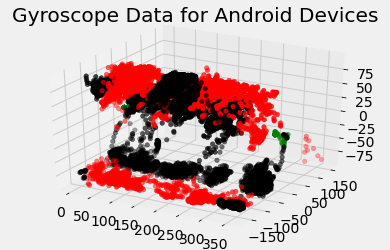

In [33]:
zdata = df[df["sensortype"] == "gyroscope"][df["device"] == "ios"]["z"]
xdata = df[df["sensortype"] == "gyroscope"][df["device"] == "ios"]["x"]
ydata = df[df["sensortype"] == "gyroscope"][df["device"] == "ios"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[gyro_colors_ios])
plt.title("Gyroscope Data for Android Devices")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Text(0.5, 0.92, 'Gyroscope Data for Android Devices')

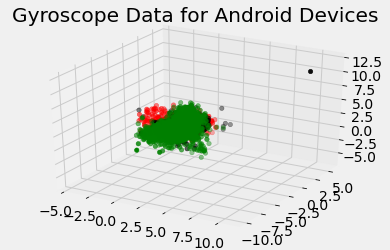

In [34]:
zdata = df[df["sensortype"] == "gyroscope"][df["device"] == "android"]["z"]
xdata = df[df["sensortype"] == "gyroscope"][df["device"] == "android"]["x"]
ydata = df[df["sensortype"] == "gyroscope"][df["device"] == "android"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[gyro_colors_android])
plt.title("Gyroscope Data for Android Devices")

In [35]:
df_sorted = df_sorted[df_sorted["sensortype"]=="accelerometer"]

### Akzelerometer untersuchen

In [36]:
df_sorted.head(21)
### We can see that there are 20 values per second from the accelerometer

,id,username,sensortype,x,y,z,ts,class,device,timestamp,class_num
19500,19501,Max,accelerometer,0.149178,0.104440,-9.754576,1617956016639,lying,ios,2021-04-09 08:13:36.639,0
19502,19503,Max,accelerometer,0.153667,0.100550,-9.762058,1617956016690,lying,ios,2021-04-09 08:13:36.690,0
19504,19505,Max,accelerometer,0.155613,0.098604,-9.753380,1617956016739,lying,ios,2021-04-09 08:13:36.739,0
19506,19507,Max,accelerometer,0.152620,0.100250,-9.755774,1617956016790,lying,ios,2021-04-09 08:13:36.790,0
19508,19509,Max,accelerometer,0.149926,0.098155,-9.749639,1617956016840,lying,ios,2021-04-09 08:13:36.840,0
19510,19511,Max,accelerometer,0.151123,0.098006,-9.757270,1617956016890,lying,ios,2021-04-09 08:13:36.890,0
19512,19513,Max,accelerometer,0.157708,0.100550,-9.755324,1617956016940,lying,ios,2021-04-09 08:13:36.940,0
19514,19515,Max,accelerometer,0.156062,0.099053,-9.753079,1617956016990,lying,ios,2021-04-09 08:13:36.990,0
19516,19517,Max,accelerometer,0.150974,0.094265,-9.759215,1617956017039,lying,ios,2021-04-09 08:13:37.039,0
19518,19519,Max,accelerometer,0.150824,0.103243,-9.762806,1617956017090,lying,ios,2021-04-09 08:13:37.090,0


In [37]:
df_sorted.describe()

,id,x,y,z,ts,class_num
count,54549.000000,54549.000000,54549.000000,54549.000000,5.454900e+04,54549.000000
mean,54544.841005,0.434548,0.326304,1.698150,1.618118e+12,0.995527
std,31498.374157,6.255843,6.926642,5.488885,1.348806e+08,0.742997
min,2.000000,-29.163322,-25.500000,-29.000000,1.617886e+12,0.000000
25%,27260.000000,-3.600000,-5.235671,-1.200000,1.617958e+12,0.000000
50%,54546.000000,0.100000,0.300000,0.600000,1.618206e+12,1.000000
75%,81824.000000,4.973805,5.829433,6.800000,1.618206e+12,2.000000
max,109098.000000,28.100000,24.890570,28.200000,1.618207e+12,2.000000


In [38]:
accel_colors = df_sorted["class_num"]

Text(0.5, 0.92, 'Accelerometer Data for both Device Types')

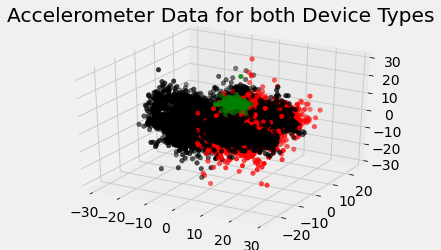

In [39]:
# Data for three-dimensional scattered points
zdata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["z"]
xdata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["x"]
ydata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[accel_colors])
plt.title("Accelerometer Data for both Device Types")

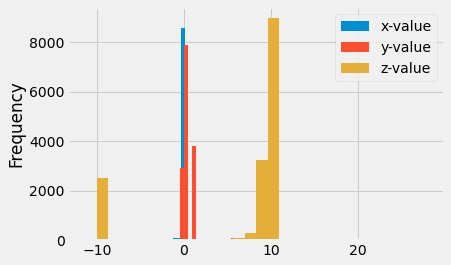

In [40]:
df_sorted[df_sorted["class"] == "lying"]["x"].plot.hist(bins=30, label="x-value")
df_sorted[df_sorted["class"] == "lying"]["y"].plot.hist(bins=30, label="y-value")
df_sorted[df_sorted["class"] == "lying"]["z"].plot.hist(bins=30, label="z-value")
plt.legend()

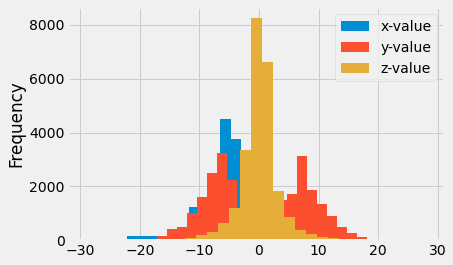

In [41]:
df_sorted[df_sorted["class"] == "walking"]["x"].plot.hist(bins=30, label="x-value")
df_sorted[df_sorted["class"] == "walking"]["y"].plot.hist(bins=30, label="y-value")
df_sorted[df_sorted["class"] == "walking"]["z"].plot.hist(bins=30, label="z-value")
plt.legend()

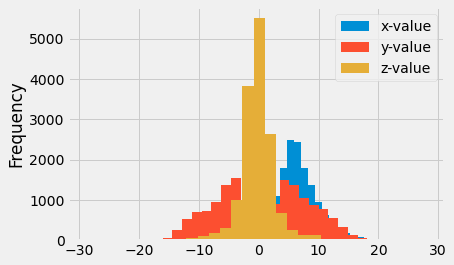

In [42]:
df_sorted[df_sorted["class"] == "stairs"]["x"].plot.hist(bins=30, label="x-value")
df_sorted[df_sorted["class"] == "stairs"]["y"].plot.hist(bins=30, label="y-value")
df_sorted[df_sorted["class"] == "stairs"]["z"].plot.hist(bins=30, label="z-value")
plt.legend()

In [43]:
classes = list(set(df_sorted["class"]))
classes

['lying', 'stairs', 'walking']

In [44]:
len(df_sorted.index)

54549

### Put the data into a format feaseable for Machine Learning and Aggregate the data to a certain time window

In [45]:
entries_to_agg = 10
df_new = pd.DataFrame()
my_list = []
my_list_labels = []
my_timestamps = []
for i in range(0,len(df_sorted.index),entries_to_agg):
        my_list.append(df_sorted.iloc[i:i+entries_to_agg,[3,4,5]].values)
        my_list_labels.append(df_sorted.iloc[i:i+entries_to_agg,7].values)
        my_timestamps.append((df_sorted.iloc[i:i+entries_to_agg,9].values))
        if i == 0:
            print(my_list_labels)

[array(['lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying'], dtype=object)]


In [46]:
df_new["time_window"] = my_timestamps
df_new["values"] = my_list
df_new["classes_in_time_window"] = my_list_labels

In [47]:
len(df_new)

5455

In [48]:
df_new.head()

,time_window,values,classes_in_time_window
0,"[2021-04-09T08:13:36.639000000, 2021-04-09T08:...","[[0.14917819, 0.104440264, -9.754576], [0.1536...","[lying, lying, lying, lying, lying, lying, lyi..."
1,"[2021-04-09T08:13:37.139000000, 2021-04-09T08:...","[[0.15621117, 0.092768535, -9.749189], [0.1550...","[lying, lying, lying, lying, lying, lying, lyi..."
2,"[2021-04-09T08:13:37.640000000, 2021-04-09T08:...","[[0.1547148, 0.09621018, -9.747543], [0.156360...","[lying, lying, lying, lying, lying, lying, lyi..."
3,"[2021-04-09T08:13:38.139000000, 2021-04-09T08:...","[[0.15815647, 0.10294388, -9.772383], [0.15920...","[lying, lying, lying, lying, lying, lying, lyi..."
4,"[2021-04-09T08:13:38.639000000, 2021-04-09T08:...","[[0.15561262, 0.09995113, -9.757718], [0.16234...","[lying, lying, lying, lying, lying, lying, lyi..."


In [49]:
df_new["time_window"][0]

array(['2021-04-09T08:13:36.639000000', '2021-04-09T08:13:36.690000000',
       '2021-04-09T08:13:36.739000000', '2021-04-09T08:13:36.790000000',
       '2021-04-09T08:13:36.840000000', '2021-04-09T08:13:36.890000000',
       '2021-04-09T08:13:36.940000000', '2021-04-09T08:13:36.990000000',
       '2021-04-09T08:13:37.039000000', '2021-04-09T08:13:37.090000000'],
      dtype='datetime64[ns]')

In [50]:
data_flat = []
class_in_time_window = []
timewindow_start = []
for i in range(0,len(df_new)-5,1):
    values = np.concatenate((df_new["values"][i]), axis=None)
    classes = np.concatenate((df_new["classes_in_time_window"][i]), axis=None)
    timewindow = np.concatenate((df_new["time_window"][i]), axis=None)
    data_flat.append(values)
    class_in_time_window.append(classes[0])
    timewindow_start.append(timewindow[0])

In [51]:
timewindow_start[0]

numpy.datetime64('2021-04-09T08:13:36.639000000')

In [52]:
timewindow_start[1]

numpy.datetime64('2021-04-09T08:13:37.139000000')

In [53]:
timewindow_start[1] - timewindow_start[0]
## exakt eine halbe Sekunde!

numpy.timedelta64(500000000,'ns')

In [54]:
len(data_flat[0])

30

In [55]:
class_in_time_window[0]

'lying'

### Putting everything into a function

In [56]:
def aggregate_data(df, entries_to_agg=10):
    df_new = pd.DataFrame()
    my_list = []
    my_list_labels = []
    my_timestamps = []
    for i in range(0,len(df.index),entries_to_agg):
            my_list.append(df.iloc[i:i+entries_to_agg,[3,4,5]].values)
            my_list_labels.append(df.iloc[i:i+entries_to_agg,7].values)
            my_timestamps.append((df.iloc[i:i+entries_to_agg,9].values))
    df_new["time_window"] = my_timestamps
    df_new["values"] = my_list
    df_new["classes_in_time_window"] = my_list_labels

    data_flat = []
    class_in_time_window = []
    timewindow_start = []
    for i in range(0,len(df_new)-5,1):
        values = np.concatenate((df_new["values"][i]), axis=None)
        classes = np.concatenate((df_new["classes_in_time_window"][i]), axis=None)
        timewindow = np.concatenate((df_new["time_window"][i]), axis=None)
        data_flat.append(values)
        class_in_time_window.append(classes[0])
        timewindow_start.append(timewindow[0])
    return data_flat, class_in_time_window, timewindow_start

In [57]:
train_X_agg, train_y_agg, time_window = aggregate_data(df_sorted)

In [58]:
set(train_y_agg)

{'lying', 'stairs', 'walking'}

In [59]:
len(train_X_agg[0])

30

In [60]:
time_window[500]

numpy.datetime64('2021-04-12T05:38:49.813000000')

In [61]:
df_prepared = pd.DataFrame(list(zip(train_X_agg, train_y_agg, time_window)), columns=["values", "labels", "time_window_start"])

In [62]:
df_prepared.head()

,values,labels,time_window_start
0,"[0.14917819, 0.104440264, -9.754576, 0.1536673...",lying,2021-04-09 08:13:36.639
1,"[0.15621117, 0.092768535, -9.749189, 0.1550140...",lying,2021-04-09 08:13:37.139
2,"[0.1547148, 0.09621018, -9.747543, 0.1563608, ...",lying,2021-04-09 08:13:37.640
3,"[0.15815647, 0.10294388, -9.772383, 0.15920393...",lying,2021-04-09 08:13:38.139
4,"[0.15561262, 0.09995113, -9.757718, 0.16234632...",lying,2021-04-09 08:13:38.639


In [63]:
len(df_prepared["values"][0])

30

### Save prepared data preserving format

In [64]:
filename = "sensor_data_prepared.pkl"
df_prepared.to_pickle(filename)

In [65]:
!ls

sensor_data_prepared.pkl


## create Project-ID & Project Token

In [66]:
project_id = "4b787fdc-f324-4243-ac37-862ad88578d6"
project_token = "p-38ed25004e585910813c8e45e08804ee19ecb155"

In [67]:
import io
from project_lib import Project
sc= None

project = Project(sc,project_id,project_token)

with open(filename, 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(
            filename, data, set_project_asset=True, overwrite=True
        )

### save modified version for OpenScale and AutoAI as csv

In [68]:
column_names = []
sensor_labels = ["x", "y", "z"]    ### change to this when gyroscope is included: ["x", "y", "z", "alpha", "gamma", "beta"]
iterations = int(len(df_prepared["values"].tolist()[0])/int(len(sensor_labels)))
for i in range(0,iterations, 1):
    sensor_labels_temp = [ current_label + "_" + str(i+1) for current_label in sensor_labels]
    column_names.append(sensor_labels_temp)
column_names = np.concatenate(column_names, axis=None)

In [69]:
df_prepared_autoai = pd.DataFrame(df_prepared["values"].tolist(), columns=column_names)

In [70]:
df_prepared_autoai["classes"] = df_prepared["labels"]
df_prepared_autoai["time_window"] = df_prepared["time_window_start"]

In [71]:
df_prepared_autoai.head()

,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,...,y_8,z_8,x_9,y_9,z_9,x_10,y_10,z_10,classes,time_window
0,0.149178,0.104440,-9.754576,0.153667,0.100550,-9.762058,0.155613,0.098604,-9.753380,0.152620,...,0.099053,-9.753079,0.150974,0.094265,-9.759215,0.150824,0.103243,-9.762806,lying,2021-04-09 08:13:36.639
1,0.156211,0.092769,-9.749189,0.155014,0.101896,-9.739463,0.154715,0.102345,-9.752481,0.153518,...,0.104440,-9.751135,0.153817,0.102794,-9.757868,0.148280,0.094564,-9.757569,lying,2021-04-09 08:13:37.139
2,0.154715,0.096210,-9.747543,0.156361,0.098305,-9.766548,0.160401,0.106834,-9.758766,0.154116,...,0.098155,-9.757719,0.168332,0.108630,-9.745897,0.160251,0.106685,-9.758467,lying,2021-04-09 08:13:37.640
3,0.158156,0.102944,-9.772383,0.159204,0.105787,-9.761160,0.149627,0.102944,-9.763704,0.155014,...,0.095013,-9.752631,0.153817,0.096210,-9.765650,0.146784,0.098155,-9.750686,lying,2021-04-09 08:13:38.139
4,0.155613,0.099951,-9.757718,0.162346,0.093666,-9.756372,0.152321,0.101896,-9.762058,0.161598,...,0.109079,-9.757719,0.146335,0.102794,-9.752781,0.152321,0.097407,-9.757869,lying,2021-04-09 08:13:38.639


In [72]:
project.save_data(file_name = "sensor_data_prepared_autoai.csv",data = df_prepared_autoai.to_csv(index=False), set_project_asset=True, overwrite=True)

{'file_name': 'sensor_data_prepared_autoai.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'iotsmartphoneml-donotdelete-pr-pfaqf77fi8ycdy',
 'asset_id': 'f2bfac2a-9894-4838-8870-79e856b6e34d'}